100
[255   0   0]


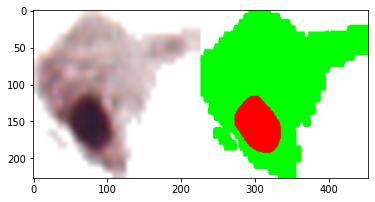

In [1]:
DIR = "PreliminaryGenerativeHistoPath/cyto2label_public/train/"

import os
import cv2
import matplotlib.pyplot as plt

imgs = []

for filename in os.listdir(DIR):
    path = DIR + filename
    img = cv2.imread(path)
    imgs.append(img)
    
    
print(len(imgs))
print(imgs[0][175, 300, :]) # B is stored first by cv2
plt.imshow(imgs[0])

In [4]:
import numpy as np


pixel = {"cytoplasm" : np.array([0, 255, 0]), "nucleus" : np.array([255, 0, 0])}
DIR = "data/train/"
instance = {}
filename = "100.png"
mask = cv2.imread(DIR + "masks/" + filename)

instance["file_name"] = DIR = "imgs/" + filename
instance["height"], instance["width"], x = mask.shape
instance["image_id"] = filename.split(".")[0]

        

In [5]:
from skimage.measure import label
from pycocotools.mask import encode
from detectron2.structures import BoxMode

def getComponents(mask):
    labels, num = label(mask, return_num=True)
    object_masks = []
    for i in range(1, num+1):
        object_masks.append(np.array((labels == i), dtype=np.uint8))
    return object_masks

annos = []
for ID, cls in enumerate(pixel):
    bn_mask = np.array((mask == pixel[cls]).all(axis=2), dtype=int)
    object_masks = getComponents(bn_mask)
   
    for object_mask in object_masks:
        annotation = {}
        rle = encode(np.asarray(object_mask, order="F"))
        points = np.argwhere(object_mask > 0)
        x, y = points[:, 0], points[:, 1]
        
        annotation["bbox"] = [np.min(x), np.min(y), np.max(x), np.max(y)]
        print(annotation["bbox"])
        annotation["bbox_mode"] = BoxMode.XYXY_ABS
        annotation["category_id"] = ID
        annotation["segmentation"] = rle
        annos.append(annotation)
        
        
instance["annotations"] = annos

[0, 0, 226, 226]
[17, 0, 54, 11]
[35, 155, 94, 211]
[137, 70, 174, 129]


In [6]:
instance

{'file_name': 'imgs/100.png',
 'height': 227,
 'width': 227,
 'image_id': '100',
 'annotations': [{'bbox': [0, 0, 226, 226],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'segmentation': {'size': [227, 227],
    'counts': b'R4n0U600:kJROa3n0_LROa3n0_LROa3n0_LROa3n0_LRO\\3Z1SL]O`3c0`L]O`3c0`L]O`3c0^L_Ob3a0^L_Ob3Q200000000000000000000000002N00000000000000000`M[Mb0e2^O[Mb0e2^O[Mb0e2^O[Mb0e2^O[Mb0e2TOTN=l1CTN=l1CTN=l1CTN=l1CTN=l1^OaN7b1I^N7b1I^N5d1K\\N5d1K\\N5d1CkN6U1JkN6U1JkN6U1JkN6U1JkN6U1HPO5P1KPO5P1HUO6k0JUO6k0JUO6k0JUO6k0JUO6k0JXO3h0MXO3h0MXO3h0MZO1f0OZO1f0MDK<5DK<5DK<5DKeM0i15b0KeM0i10i0N[M7j1Kk0N[M7j1Kk0N[M7j1Kk0N[M:g1Hn0N[M:g1CS10YM=d1CS10YM=d1CS10YM=d1CS10YM?b1AU10YM?b1An1l0eMTO[2l0eMTO[2l0eMTO[2Q1`MoN`2Q1`MlNc2T1[MnNe2R1[MnNe2R1[MnNe2R1[MnNe2R1[MnNh2o0SMVOm2j0SMVOm2j0SMVOm2j0SMVOm2j0SMVOm2g0VMYOj2g0VMYOj2g0VMYOl2c0VM]Oj2c0VM[Ol2e0TM[Ol2e0TM[Ol2e0TM[Oo2?TMAl2?TMAl2=SMFm2:SMFm2:SMFm2:SMFm2:SMFo28QMHo28QMHo28QMHo28QMHo28QMHR32oL0Q30oL0Q30oL0Q30lL3T3MlL3T3MlL3T3MlL3T

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from convert_coco import get_cell_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("cell_" + d, lambda d=d: get_cell_dicts("data/" + d + "/"))
    MetadataCatalog.get("cell_" + d).set(thing_classes=["cytoplasm", "nucleus"])

In [20]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cell_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.005  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000 
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
cfg.INPUT.MASK_FORMAT='bitmask'
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/02 23:48:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[07/02 23:48:27 d2.engine.train_loop]: Starting training from iteration 0


/home/tarushii/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/detectron2/data/detection_utils.py:419: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/tarushii/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/detectron2/data/detection_utils.py:419: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its

[07/02 23:48:32 d2.utils.events]:  eta: 0:17:54  iter: 19  total_loss: 2.732  loss_cls: 0.9202  loss_box_reg: 0.6662  loss_mask: 0.6913  loss_rpn_cls: 0.3781  loss_rpn_loc: 0.06157  time: 0.2174  data_time: 0.0260  lr: 9.9905e-05  max_mem: 2113M
[07/02 23:48:36 d2.utils.events]:  eta: 0:17:56  iter: 39  total_loss: 2.034  loss_cls: 0.4896  loss_box_reg: 0.6058  loss_mask: 0.6811  loss_rpn_cls: 0.1694  loss_rpn_loc: 0.06242  time: 0.2172  data_time: 0.0049  lr: 0.0001998  max_mem: 2113M
[07/02 23:48:40 d2.utils.events]:  eta: 0:17:47  iter: 59  total_loss: 1.777  loss_cls: 0.3498  loss_box_reg: 0.5267  loss_mask: 0.6712  loss_rpn_cls: 0.1161  loss_rpn_loc: 0.04726  time: 0.2168  data_time: 0.0047  lr: 0.0002997  max_mem: 2113M
[07/02 23:48:45 d2.utils.events]:  eta: 0:17:40  iter: 79  total_loss: 1.671  loss_cls: 0.2906  loss_box_reg: 0.436  loss_mask: 0.6537  loss_rpn_cls: 0.1725  loss_rpn_loc: 0.06554  time: 0.2155  data_time: 0.0049  lr: 0.00039961  max_mem: 2113M
[07/02 23:48:49 d2.

In [21]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [22]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_cell_dicts("data/val/")
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) #read about the format here: https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-output-format
    print(outputs["instances"])

Instances(num_instances=2, image_height=227, image_width=227, fields=[pred_boxes: Boxes(tensor([[188.5186, 188.9953, 226.7700, 225.9638],
        [  0.0000,   0.0000, 227.0000, 224.4529]], device='cuda:0')), scores: tensor([0.9968, 0.9967], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
   

In [4]:
%env DISPLAY=192.168.5.112:0.0

env: DISPLAY=192.168.5.112:0.0


In [ ]:
cv2.imshow("test", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
img.shape

(113, 113, 3)

In [12]:
out.save("test.png")

In [16]:
outputs["instances"]

Instances(num_instances=0, image_height=227, image_width=227, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])